## VGG11

In [1]:
%load_ext autoreload
%autoreload 2

import warnings

import torch
from cifar_utils import (
    fhe_compatibility,
    fhe_simulation_inference,
    get_dataloader,
    plot_dataset,
    torch_inference,
)
from models import QuantVGG11
from torchvision import datasets

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
bit = 5
seed = 42

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device Type: {device}")

param_c10 = {
    "output_size": 10,
    "batch_size": 32,
    "dataset_name": "CIFAR_10",
    "dataset": datasets.CIFAR10,
    "std": [0.247, 0.243, 0.261],
    "mean": [0.4914, 0.4822, 0.4465],
    "dir": "./checkpoints/CIFAR_10",
    "pre_trained_path": "quant/CIFAR_10_quant_state_dict.pt",
    "seed": 42,
}

Device Type: cuda


## Models

In [3]:
# Load CIFAR-10 data-set.
train_loader_c10, test_loader_c10 = get_dataloader(param=param_c10, debug=1000)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Loading the pre-trained quantized model.
# vgg_11 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)
quant_vgg_c10 = QuantVGG11(bit=bit, output_size=param_c10["output_size"])
quant_vgg_c10.load_state_dict(torch.load(f"{param_c10['dir']}/{param_c10['pre_trained_path']}", map_location=device))

<All keys matched successfully>

In [5]:
data_calibration, _ = next(iter(train_loader_c10))
qmodel_c10 = fhe_compatibility(quant_vgg_c10, data_calibration)

print(
    f"Maximum bit-width in the circuit: {qmodel_c10.fhe_circuit.graph.maximum_integer_bit_width()}"
)

Maximum bit-width in the circuit: 14


In [6]:
cm_fhe_c10 = fhe_simulation_inference(qmodel_c10, test_loader_c10, mode="simulate", verbose=True)

  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [05:00<00:00,  9.71s/it]


In [7]:
cm_torch_c10 = torch_inference(quant_vgg_c10, test_loader_c10, device=device, verbose=True)

100%|██████████| 31/31 [00:13<00:00,  2.30it/s]


In [8]:
cm_fhe_c10

array([[106,   2,   1,   2,   0,   1,   0,   0,   1,   0],
       [  1, 106,   0,   1,   1,   0,   0,   0,   1,   4],
       [  0,   0,  87,   1,   2,   0,   2,   2,   0,   0],
       [  0,   1,   2,  89,   1,  10,   2,   2,   1,   1],
       [  0,   0,   4,   3,  77,   1,   1,   1,   0,   0],
       [  0,   0,   2,   7,   1,  79,   1,   2,   0,   0],
       [  1,   0,   3,   0,   0,   1,  93,   0,   1,   0],
       [  1,   0,   2,   2,   4,   4,   0,  87,   0,   0],
       [  1,   1,   0,   1,   0,   0,   0,   0,  94,   0],
       [  4,   2,   1,   0,   0,   0,   0,   0,   0,  80]])

In [9]:
cm_torch_c10

array([[103,   3,   2,   2,   0,   1,   0,   0,   1,   0],
       [  1, 106,   0,   1,   1,   0,   0,   0,   2,   5],
       [  0,   0,  88,   1,   2,   0,   3,   3,   0,   0],
       [  0,   0,   1,  92,   1,   7,   2,   3,   2,   1],
       [  0,   0,   3,   3,  75,   1,   2,   2,   0,   0],
       [  0,   0,   2,   8,   1,  79,   1,   3,   0,   0],
       [  1,   0,   2,   0,   0,   1,  93,   0,   1,   0],
       [  0,   0,   2,   2,   3,   5,   0,  88,   0,   0],
       [  2,   1,   0,   0,   0,   0,   0,   0,  92,   0],
       [  4,   2,   1,   0,   0,   0,   0,   0,   1,  77]])

## FGSM

In [10]:
import torch
import torch.nn as nn
from torch.autograd import Variable

def FGSM(model, x, y, eps, criterion):
    x_ = Variable(x.data, requires_grad=True).to(device)
    y = y.to(device)
    output = model(x_)
    loss = criterion(output, y)
    model.zero_grad()

    x_.retain_grad()
    loss.backward()

    pert_x = x_ + eps * torch.sign(x_.grad.detach())

    return pert_x

fgsm_preprocessor = lambda x, y : FGSM(quant_vgg_c10, x, y, 0.05, nn.CrossEntropyLoss())

In [11]:
cm_fhe_c10_fgsm = fhe_simulation_inference(qmodel_c10, test_loader_c10, preprocessor=fgsm_preprocessor, mode="simulate", verbose=True)

100%|██████████| 31/31 [05:28<00:00, 10.59s/it]


In [12]:
cm_torch_c10_fgsm = torch_inference(quant_vgg_c10, test_loader_c10, preprocessor=fgsm_preprocessor, device=device, verbose=True)

 48%|████▊     | 15/31 [00:01<00:01,  9.59it/s]

100%|██████████| 31/31 [00:03<00:00,  8.57it/s]


In [13]:
cm_fhe_c10_fgsm

array([[55,  6, 19,  6,  3,  2,  1,  0, 19,  1],
       [ 6, 70,  0,  1,  1,  0,  1,  0,  6, 31],
       [ 7,  0, 44, 11,  5,  6, 17,  6,  0,  1],
       [ 1,  3,  8, 13,  9, 50, 16,  5,  3,  1],
       [ 1,  0, 20, 11, 25,  7,  6, 12,  1,  1],
       [ 2,  0,  9, 43,  5, 17,  6,  9,  1,  1],
       [ 2,  1, 24, 17, 10,  1, 40,  0,  2,  2],
       [ 2,  0,  6,  7, 16, 25,  2, 42,  0,  0],
       [20,  4,  2,  2,  1,  1,  0,  0, 62,  4],
       [ 8, 26,  2,  2,  0,  1,  0,  2,  8, 37]])

In [14]:
cm_torch_c10_fgsm

array([[53,  5, 21,  6,  3,  2,  1,  0, 19,  1],
       [ 6, 68,  0,  1,  1,  0,  1,  0,  6, 30],
       [ 9,  0, 42, 11,  7,  6, 15,  6,  0,  1],
       [ 1,  3,  8, 12,  8, 50, 16,  6,  3,  1],
       [ 1,  1, 21, 10, 26,  7,  6, 13,  1,  1],
       [ 1,  0,  9, 42,  4, 19,  6, 10,  1,  2],
       [ 2,  1, 22, 21,  9,  1, 39,  0,  2,  2],
       [ 2,  0,  6,  8, 16, 24,  2, 43,  0,  0],
       [19,  4,  2,  2,  0,  1,  1,  0, 63,  4],
       [ 7, 26,  2,  2,  0,  1,  0,  1,  8, 39]])

## PGD

In [15]:
import math
import torch
import torch.nn.functional as F

def PGD(model, x, y, alpha, epsilon, iter, criterion):
    x = x.to(device)
    y = y.to(device)
    delta = torch.zeros_like(x, requires_grad=True)
    for _ in range(iter):
        loss = criterion(model(x + delta), y)
        loss.backward()
        delta.data += x.shape[0] * alpha * delta.grad.data
        delta.data = delta.data.clamp(-epsilon, epsilon)
        delta.grad.zero_()
    pert = delta.detach()
    x_adv = x + pert
    return x_adv

pgd_preprocessor = lambda x, y : PGD(quant_vgg_c10, x, y, 2, 100, 3, nn.CrossEntropyLoss())

In [16]:
cm_fhe_c10_pgd = fhe_simulation_inference(qmodel_c10, test_loader_c10, preprocessor=pgd_preprocessor, mode="simulate", verbose=True)

 13%|█▎        | 4/31 [00:42<04:48, 10.67s/it]

100%|██████████| 31/31 [05:34<00:00, 10.79s/it]


In [17]:
cm_torch_c10_pgd = torch_inference(quant_vgg_c10, test_loader_c10, preprocessor=pgd_preprocessor, device=device, verbose=True)

100%|██████████| 31/31 [00:06<00:00,  4.59it/s]


In [18]:
cm_fhe_c10_pgd

array([[82,  2,  8,  4,  2,  1,  5,  0,  7,  1],
       [ 2, 98,  0,  1,  1,  0,  0,  0,  1, 13],
       [ 5,  0, 62, 10,  2,  2,  9,  3,  1,  2],
       [ 3,  2, 10, 33,  4, 30, 18,  5,  0,  2],
       [ 2,  1, 14,  6, 48,  1,  7,  6,  1,  1],
       [ 1,  0, 10, 21,  3, 39,  5,  8,  0,  5],
       [ 1,  0,  9,  4,  3,  0, 78,  0,  2,  1],
       [ 3,  1,  8,  7,  1,  8,  5, 68,  0,  0],
       [ 8,  2,  4,  0,  0,  0,  2,  0, 80,  1],
       [ 4,  9,  4,  1,  1,  0,  2,  0,  2, 63]])

In [19]:
cm_torch_c10_pgd

array([[82,  2,  9,  4,  2,  1,  5,  0,  7,  1],
       [ 2, 98,  0,  1,  1,  0,  0,  0,  1, 13],
       [ 4,  1, 64, 10,  2,  2,  9,  3,  0,  2],
       [ 4,  2, 10, 32,  5, 31, 18,  5,  0,  2],
       [ 3,  1, 13,  5, 47,  1,  6,  6,  1,  1],
       [ 1,  0, 10, 21,  3, 41,  5,  8,  1,  4],
       [ 1,  0,  9,  5,  3,  0, 78,  0,  1,  1],
       [ 3,  1,  8,  7,  2,  6,  5, 68,  0,  0],
       [ 9,  2,  3,  0,  0,  0,  2,  0, 77,  1],
       [ 4,  9,  4,  1,  1,  0,  2,  0,  2, 64]])

In [24]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def plot_cm(cm):
    df_cm = pd.DataFrame(cm, index = range(cm.shape[0]),
                    columns = range(cm.shape[1]))
    plt.figure(figsize = (cm.shape))
    sn.heatmap(df_cm, annot=True)
    plt.show()

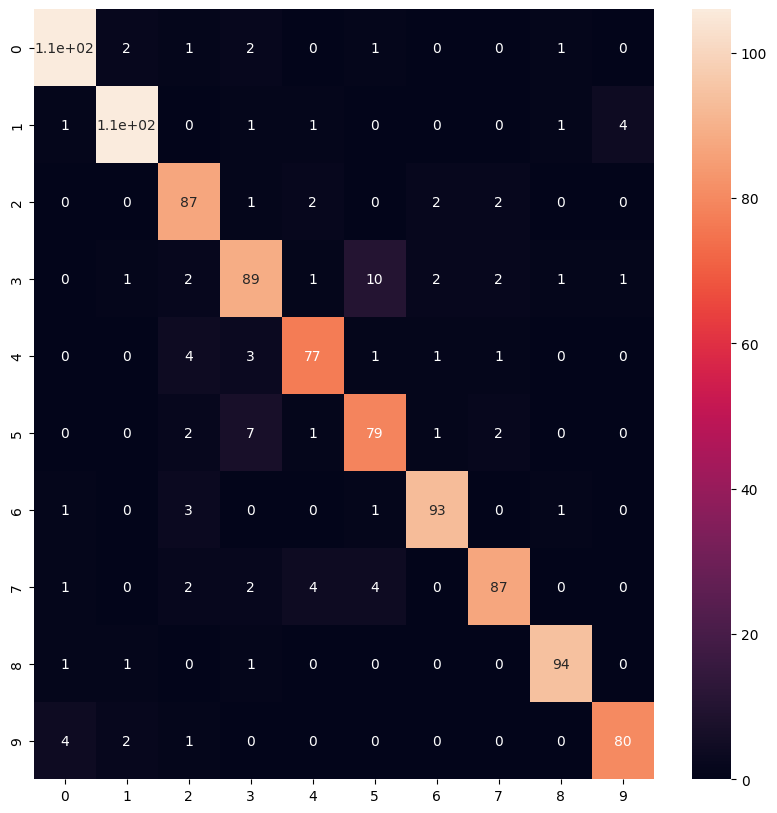

In [29]:
plot_cm(cm_fhe_c10)

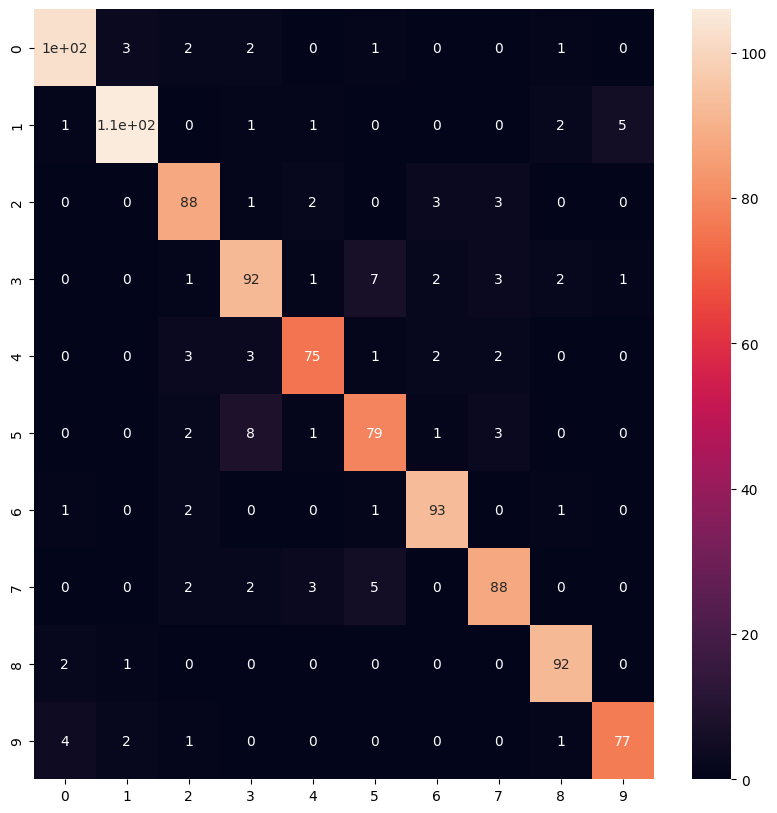

In [30]:
plot_cm(cm_torch_c10)

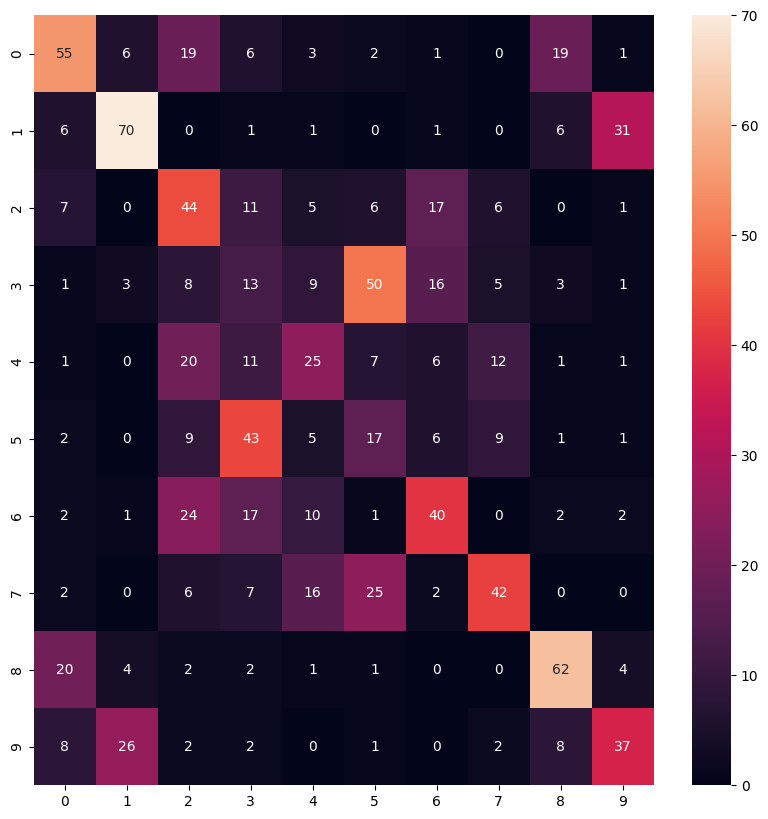

In [25]:
plot_cm(cm_fhe_c10_fgsm)

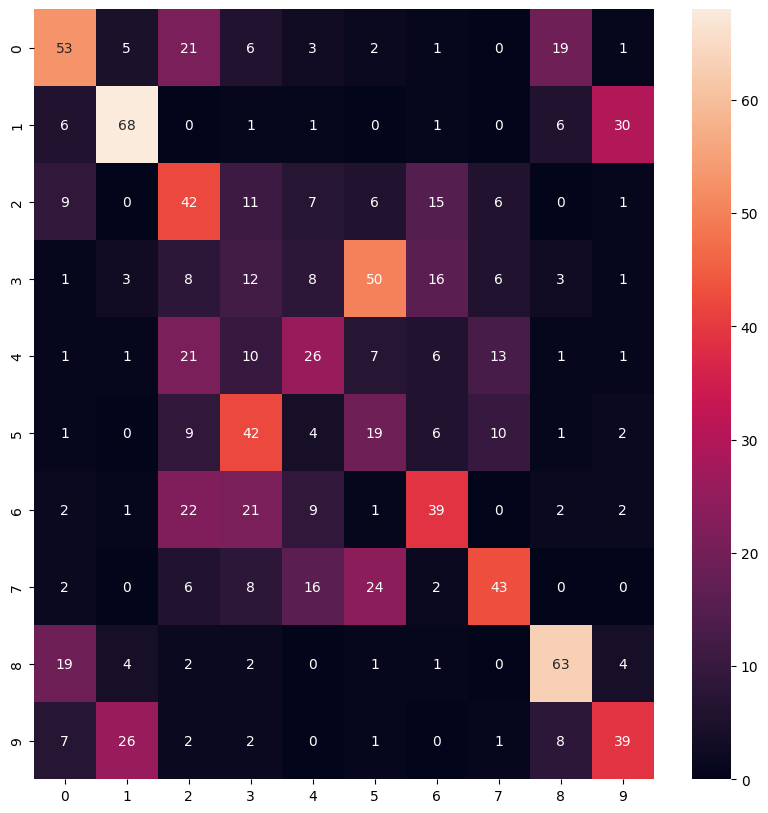

In [26]:
plot_cm(cm_torch_c10_fgsm)

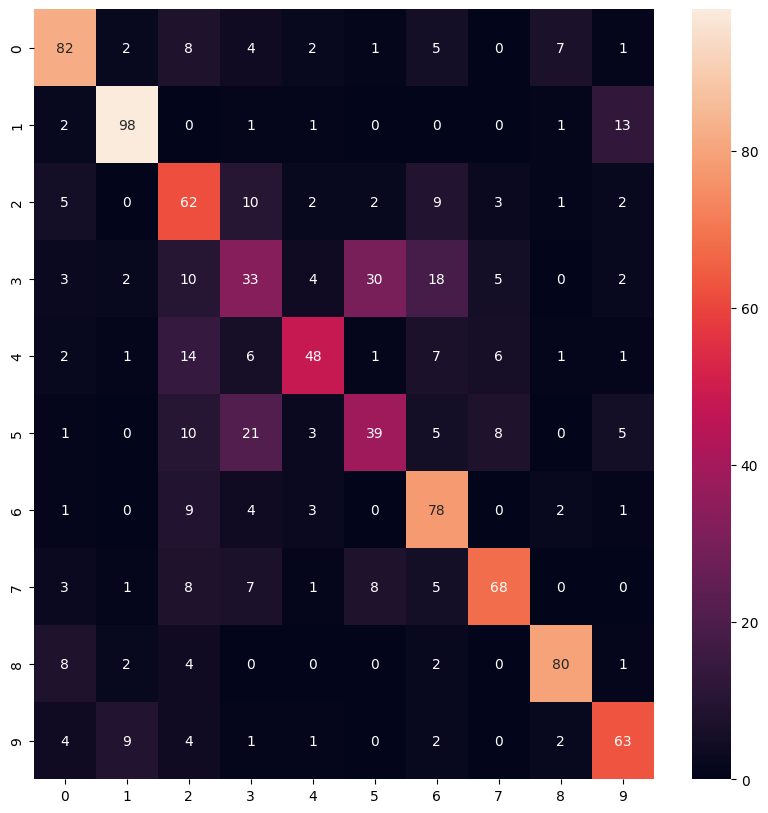

In [27]:
plot_cm(cm_fhe_c10_pgd)

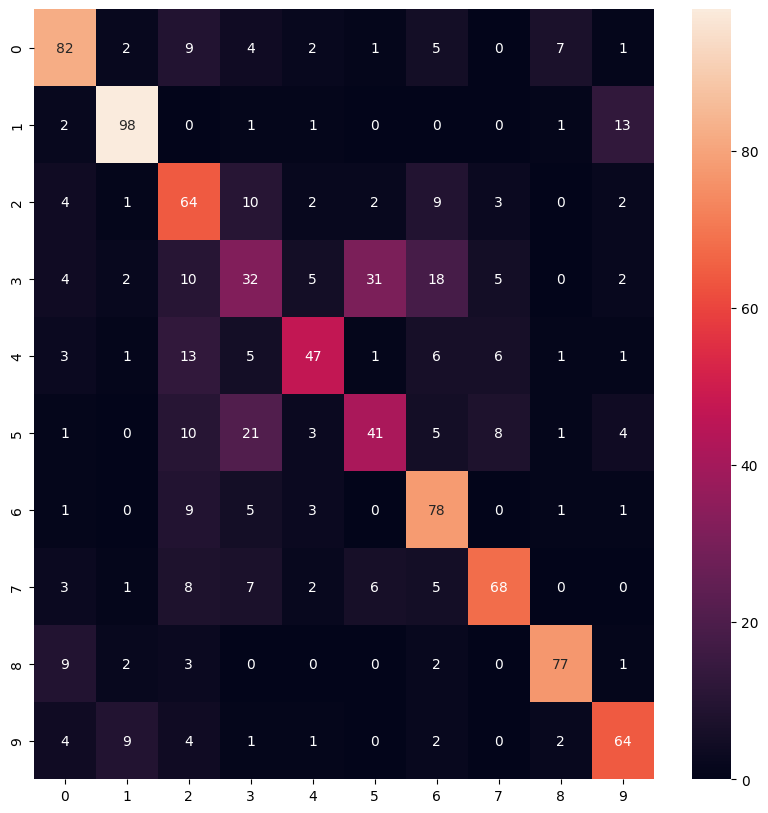

In [28]:
plot_cm(cm_torch_c10_pgd)